In [12]:
import requests
page = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
page

<Response [200]>

In [13]:
import folium

In [14]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(page.content, 'html.parser')
! pip install geopy

In [15]:
# getting the
data = []
table = soup.find('table', attrs={'class':'wikitable sortable'})
table_body = table.find('tbody')

rows = table_body.find_all('tr')
for row in rows:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    data.append([ele for ele in cols if ele]) 

In [16]:
data
import pandas as pd 
df= pd.DataFrame(data)

In [17]:
df.head()

,0,1,2
0,None,None,None
1,M1A,Not assigned,Not assigned
2,M2A,Not assigned,Not assigned
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village


In [18]:
# removing the not assigned fields 
for i,v in df.iterrows():
    if (v[1]) == 'Not assigned':
        df.drop(i,inplace = True)
df.drop(0,inplace = True)        

In [19]:
df.head()

,0,1,2
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,"Regent Park, Harbourfront"
6,M6A,North York,"Lawrence Manor, Lawrence Heights"
7,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [20]:
df.columns= ['Postal Code','Borough','Neighbourhood']

In [21]:
df.head()

,Postal Code,Borough,Neighbourhood
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,"Regent Park, Harbourfront"
6,M6A,North York,"Lawrence Manor, Lawrence Heights"
7,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [22]:
# getting the coordinates 
cl = pd.read_csv('Geospatial_Coordinates.csv')
cl.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [23]:
# merging on the 'Postal Code' to get accurate 
final = pd.merge(df, cl, on="Postal Code")

In [24]:
final.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [25]:
north_york = final[final['Borough']=='North York'].reset_index(drop=True)
#manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
north_york.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
3,M3B,North York,Don Mills,43.745906,-79.352188
4,M6B,North York,Glencairn,43.709577,-79.445073


In [26]:
#map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)
import geopy
from geopy.geocoders import Nominatim


In [27]:
address = 'North York,Toronto'

geolocator = Nominatim(user_agent="ny_tor")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of North York  are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of North York  are 43.7543263, -79.44911696639593.


In [28]:
# create map of North york using latitude and longitude values
map_Northyork = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(north_york['Latitude'], north_york['Longitude'], north_york['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Northyork)  
    
map_Northyork

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

In [29]:
CLIENT_ID = 'ANRGBELPEPIIBBDO2GSKTCD4EJWKUQ0LNPRFPAGT4C530ICS' # your Foursquare ID
CLIENT_SECRET = 'JDB1ONPJDWLMDRCIUKVOYVVNAPRKZ2ZCOKGF4BFWSD2JDYQY' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
LIMIT = 100

Your credentails:
CLIENT_ID: ANRGBELPEPIIBBDO2GSKTCD4EJWKUQ0LNPRFPAGT4C530ICS
CLIENT_SECRET:JDB1ONPJDWLMDRCIUKVOYVVNAPRKZ2ZCOKGF4BFWSD2JDYQY


In [30]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [31]:
north_york_venues = getNearbyVenues(names=north_york['Neighbourhood'],
                                   latitudes=north_york['Latitude'],
                                   longitudes=north_york['Longitude']
                                  )

Parkwoods
Victoria Village
Lawrence Manor, Lawrence Heights
Don Mills
Glencairn
Don Mills
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Fairview, Henry Farm, Oriole
Northwood Park, York University
Bayview Village
Downsview
York Mills, Silver Hills
Downsview
North Park, Maple Leaf Park, Upwood Park
Humber Summit
Willowdale, Newtonbrook
Downsview
Bedford Park, Lawrence Manor East
Humberlea, Emery
Willowdale, Willowdale East
Downsview
York Mills West
Willowdale, Willowdale West


In [32]:
north_york_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


In [33]:
north_york_venues['Neighborhood'].value_counts()

Fairview, Henry Farm, Oriole                       68
Willowdale, Willowdale East                        33
Don Mills                                          27
Bedford Park, Lawrence Manor East                  25
Bathurst Manor, Wilson Heights, Downsview North    22
Downsview                                          14
Lawrence Manor, Lawrence Heights                   11
Northwood Park, York University                     7
Victoria Village                                    6
Willowdale, Willowdale West                         6
Hillcrest Village                                   4
Glencairn                                           4
Bayview Village                                     4
North Park, Maple Leaf Park, Upwood Park            4
York Mills West                                     3
Humberlea, Emery                                    2
Parkwoods                                           2
Humber Summit                                       1
Name: Neighborhood, dtype: i

In [34]:
# analysing each neighbourhood 
# one hot encoding
north_york_onehot = pd.get_dummies(north_york_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
north_york_onehot['Neighborhood'] = north_york_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [north_york_onehot.columns[-1]] + list(north_york_onehot.columns[:-1])
north_york_onehot = north_york_onehot[fixed_columns]

north_york_onehot.head()

,Neighborhood,Accessories Store,Airport,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Bakery,Bank,...,Steakhouse,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Video Game Store,Vietnamese Restaurant,Women's Store
0,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
north_york_grouped = north_york_onehot.groupby('Neighborhood').mean().reset_index()
north_york_grouped.head()

,Neighborhood,Accessories Store,Airport,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Bakery,Bank,...,Steakhouse,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Video Game Store,Vietnamese Restaurant,Women's Store
0,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.0,0.090909,...,0.0,0.045455,0.045455,0.0,0.00,0.0,0.0,0.0,0.0,0.0
1,Bayview Village,0.0,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.0,0.250000,...,0.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0
2,"Bedford Park, Lawrence Manor East",0.0,0.000000,0.04,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.040000,0.0,0.04,0.0,0.0,0.0,0.0,0.0
3,Don Mills,0.0,0.000000,0.00,0.037037,0.0,0.037037,0.000000,0.0,0.000000,...,0.0,0.037037,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0
4,Downsview,0.0,0.071429,0.00,0.000000,0.0,0.000000,0.071429,0.0,0.071429,...,0.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0


In [37]:
import numpy as np 
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]






num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = north_york_grouped['Neighborhood']

for ind in np.arange(north_york_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(north_york_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Mobile Phone Shop,Diner,Middle Eastern Restaurant,Convenience Store,Park,Pharmacy,Pizza Place,Ice Cream Shop
1,Bayview Village,Japanese Restaurant,Chinese Restaurant,Café,Bank,Women's Store,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega
2,"Bedford Park, Lawrence Manor East",Restaurant,Sandwich Place,Italian Restaurant,Coffee Shop,Pub,Hobby Shop,Liquor Store,Juice Bar,Café,Comfort Food Restaurant
3,Don Mills,Gym,Café,Sporting Goods Shop,Japanese Restaurant,Beer Store,Restaurant,Coffee Shop,Sandwich Place,Clothing Store,Chinese Restaurant
4,Downsview,Park,Grocery Store,Hotel,Airport,Food Truck,Discount Store,Business Service,Athletics & Sports,Gym / Fitness Center,Bank


## Cluster Neighborhoods

In [38]:
# set number of clusters
kclusters = 5
from sklearn.cluster import KMeans


manhattan_grouped_clustering = north_york_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 2, 1, 4], dtype=int32)

In [39]:
import matplotlib.pyplot as plt

distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i,init='k-means++',n_init=10,max_iter=300,random_state=0)
    km.fit(manhattan_grouped_clustering)
    distortions.append(km.inertia_)
plt.plot(range(1,11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.show()

<Figure size 640x480 with 1 Axes>

optimal numbers of cluster = 4 

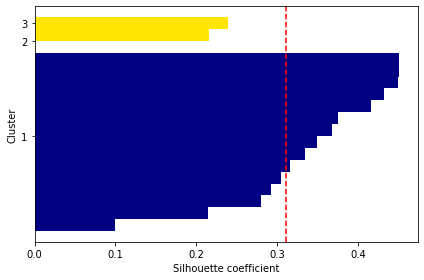

In [40]:
# checking the quality of the clusters uisng silhoutte coefficient
>>> km = KMeans(n_clusters=3,
... init='k-means++',
... n_init=10,
... max_iter=300,
... tol=1e-04,
... random_state=0)
>>> y_km = km.fit_predict(manhattan_grouped_clustering)
>>> import numpy as np
>>> from matplotlib import cm
>>> from sklearn.metrics import silhouette_samples
>>> cluster_labels = np.unique(y_km)
>>> n_clusters = cluster_labels.shape[0]
>>> silhouette_vals = silhouette_samples(manhattan_grouped_clustering,
... y_km,
... metric='euclidean')
>>> y_ax_lower, y_ax_upper = 0, 0
>>> yticks = []
>>> for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper),c_silhouette_vals,height=1.0,edgecolor='none',color=color)
        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)
>>> silhouette_avg = np.mean(silhouette_vals)
>>> plt.axvline(silhouette_avg,
... color="red",
... linestyle="--")
>>> plt.yticks(yticks, cluster_labels + 1)
>>> plt.ylabel('Cluster')
>>> plt.xlabel('Silhouette coefficient')
>>> plt.tight_layout()
>>> plt.show()

In [43]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

north_york_merged = north_york



In [44]:
 #merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
north_york_merged = north_york_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

north_york_merged.head() # check the last columns!

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,3.0,Park,Food & Drink Shop,Dim Sum Restaurant,Clothing Store,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cupcake Shop
1,M4A,North York,Victoria Village,43.725882,-79.315572,0.0,French Restaurant,Coffee Shop,Pizza Place,Hockey Arena,Portuguese Restaurant,Intersection,Women's Store,Dessert Shop,Comfort Food Restaurant,Construction & Landscaping
2,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0.0,Furniture / Home Store,Clothing Store,Accessories Store,Event Space,Coffee Shop,Boutique,Vietnamese Restaurant,Food & Drink Shop,Fast Food Restaurant,Fried Chicken Joint
3,M3B,North York,Don Mills,43.745906,-79.352188,0.0,Gym,Café,Sporting Goods Shop,Japanese Restaurant,Beer Store,Restaurant,Coffee Shop,Sandwich Place,Clothing Store,Chinese Restaurant
4,M6B,North York,Glencairn,43.709577,-79.445073,0.0,Metro Station,Sushi Restaurant,Pub,Japanese Restaurant,Women's Store,Dessert Shop,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Convenience Store


In [45]:
north_york_merged.fillna(0,inplace = True)
north_york_merged.isna().sum()

Postal Code               0
Borough                   0
Neighbourhood             0
Latitude                  0
Longitude                 0
Cluster Labels            0
1st Most Common Venue     0
2nd Most Common Venue     0
3rd Most Common Venue     0
4th Most Common Venue     0
5th Most Common Venue     0
6th Most Common Venue     0
7th Most Common Venue     0
8th Most Common Venue     0
9th Most Common Venue     0
10th Most Common Venue    0
dtype: int64

In [46]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
import matplotlib.colors as colors

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
cluster= 2
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(north_york_merged['Latitude'], north_york_merged['Longitude'], north_york_merged['Neighbourhood'],north_york_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
    
    
       
map_clusters

In [47]:
north_york_merged.loc[north_york_merged['Cluster Labels'] == 0, north_york_merged.columns[[1] + list(range(5, north_york_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,North York,0.0,French Restaurant,Coffee Shop,Pizza Place,Hockey Arena,Portuguese Restaurant,Intersection,Women's Store,Dessert Shop,Comfort Food Restaurant,Construction & Landscaping
2,North York,0.0,Furniture / Home Store,Clothing Store,Accessories Store,Event Space,Coffee Shop,Boutique,Vietnamese Restaurant,Food & Drink Shop,Fast Food Restaurant,Fried Chicken Joint
3,North York,0.0,Gym,Café,Sporting Goods Shop,Japanese Restaurant,Beer Store,Restaurant,Coffee Shop,Sandwich Place,Clothing Store,Chinese Restaurant
4,North York,0.0,Metro Station,Sushi Restaurant,Pub,Japanese Restaurant,Women's Store,Dessert Shop,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Convenience Store
5,North York,0.0,Gym,Café,Sporting Goods Shop,Japanese Restaurant,Beer Store,Restaurant,Coffee Shop,Sandwich Place,Clothing Store,Chinese Restaurant
7,North York,0.0,Coffee Shop,Bank,Mobile Phone Shop,Diner,Middle Eastern Restaurant,Convenience Store,Park,Pharmacy,Pizza Place,Ice Cream Shop
8,North York,0.0,Clothing Store,Coffee Shop,Fast Food Restaurant,Restaurant,Convenience Store,Jewelry Store,Japanese Restaurant,Bakery,Bank,Women's Store
9,North York,0.0,Vietnamese Restaurant,Furniture / Home Store,Caribbean Restaurant,Metro Station,Massage Studio,Bar,Coffee Shop,Dim Sum Restaurant,Construction & Landscaping,Convenience Store
10,North York,0.0,Japanese Restaurant,Chinese Restaurant,Café,Bank,Women's Store,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega
11,North York,0.0,Park,Grocery Store,Hotel,Airport,Food Truck,Discount Store,Business Service,Athletics & Sports,Gym / Fitness Center,Bank


In [48]:
north_york_merged.loc[north_york_merged['Cluster Labels'] == 1, north_york_merged.columns[[1] + list(range(5, north_york_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,North York,1.0,Construction & Landscaping,Women's Store,Vietnamese Restaurant,Coffee Shop,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store


In [49]:
north_york_merged.loc[north_york_merged['Cluster Labels'] == 2, north_york_merged.columns[[1] + list(range(5, north_york_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,North York,2.0,Golf Course,Mediterranean Restaurant,Pool,Dog Run,Dim Sum Restaurant,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop


In [50]:
north_york_merged.loc[north_york_merged['Cluster Labels'] == 3, north_york_merged.columns[[1] + list(range(5, north_york_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,3.0,Park,Food & Drink Shop,Dim Sum Restaurant,Clothing Store,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cupcake Shop
22,North York,3.0,Park,Convenience Store,Gas Station,Clothing Store,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Cosmetics Shop,Cupcake Shop,Deli / Bodega


In [54]:
north_york_merged.loc[north_york_merged['Cluster Labels'] == 4, north_york_merged.columns[[1] + list(range(5, north_york_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,North York,4.0,Baseball Field,Paper / Office Supplies Store,Women's Store,Diner,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cupcake Shop


 comparing diffrent clusters we see some diffrences for example the first cluster is definately more public bars,gyms restraunts,coffee shops  etc and the second cluster label covers spots that are essential but not everyday and cluster label 3 covers public parks each cluster serve diffrent purpose depending on the problem we are trying to solve.